## Explainable Disease Classification with Uncertainty

Train a neural network on TCGA+GTEX gene expression data to classify disease.

Try out the following three shiny shiny:

Hyperband

[SHAP (SHapley Additive exPlanations)](https://github.com/slundberg/shap)

[Dropout based uncertainty measurement](https://hjweide.github.io/quantifying-uncertainty-in-neural-networks)

In [1]:
import os
import json
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

# fix random seed for reproducibility
np.random.seed(42)

# See https://github.com/h5py/h5py/issues/712
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" 

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load and Wrangle Data

In [2]:
X = pd.read_hdf("data/tcga_target_gtex.h5", "expression")
Y = pd.read_hdf("data/tcga_target_gtex.h5", "labels")

In [3]:
# Prune X to only KEGG pathway genes
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    genes = list(set().union(*[line.strip().split("\t")[2:] for line in f.readlines()]))
X_pruned = X.drop(labels=(set(X.columns) - set(genes)), axis=1, errors="ignore")
print("Pruned expression to only include", len(genes), "genes")

Pruned expression to only include 5266 genes


In [4]:
# Create a one-hot for disease
from sklearn.preprocessing import LabelEncoder
disease_encoder = LabelEncoder()
Y["disease_value"] = pd.Series(disease_encoder.fit_transform(Y.disease), index=Y.index)

from sklearn.preprocessing import LabelBinarizer
disease_binarizer = LabelBinarizer()
y = disease_binarizer.fit_transform(Y.disease)

In [5]:
# Divide into training and test sets strattified by disease
# Split into stratified training and test sets based primary site
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X.values, Y.disease):
    X_train = X_pruned.values[train_index]
    X_test = X_pruned.values[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    disease_train = Y.disease_value.values[train_index]
    disease_test = Y.disease_value.values[test_index]

print(X_train.shape, X_test.shape)

(15300, 5172) (3826, 5172)


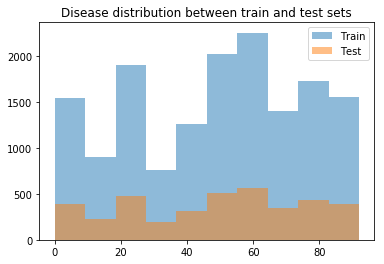

In [6]:
# Lets see how big each class is based on primary site
plt.hist(disease_train, alpha=0.5, label='Train')
plt.hist(disease_test, alpha=0.5, label='Test')
plt.legend(loc='upper right')
plt.title("Disease distribution between train and test sets")
plt.show()

# Build and Train Model

In [7]:
%%time
from keras.models import Model
from keras.layers import Input, BatchNormalization, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

def create_model(input_shape, output_shape, params):
    inputs = Input(shape=(input_shape,))

    x = BatchNormalization()(inputs)

    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activity_regularizer=regularizers.l1(1e-5), activation="relu")(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(output_shape, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

model = create_model(X_train.shape[1], y_train.shape[1], {})

callbacks = [EarlyStopping(monitor="acc", min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train, epochs=10, batch_size=128, shuffle="batch", callbacks=callbacks)
print(model.metrics_names, model.evaluate(X_test, y_test))

Epoch 1/10
15300/15300 [==============================] - 3s 219us/step - loss: 2.6685 - acc: 0.4303
Epoch 2/10
15300/15300 [==============================] - 3s 196us/step - loss: 1.4307 - acc: 0.6663
Epoch 3/10
15300/15300 [==============================] - 4s 233us/step - loss: 1.1136 - acc: 0.7402
Epoch 4/10
15300/15300 [==============================] - 3s 201us/step - loss: 0.9403 - acc: 0.7814
Epoch 5/10
15300/15300 [==============================] - 3s 194us/step - loss: 0.8286 - acc: 0.8063
Epoch 6/10
15300/15300 [==============================] - 3s 194us/step - loss: 0.7748 - acc: 0.8212
Epoch 7/10
15300/15300 [==============================] - 3s 192us/step - loss: 0.7393 - acc: 0.8287
Epoch 00007: early stopping
3826/3826 [==============================] - 1s 148us/step
['loss', 'acc'] [0.31387478860958795, 0.9158389963719836]
CPU times: user 9min 9s, sys: 12min 6s, total: 21min 15s
Wall time: 23.2 s


In [8]:
# Save the model for separate inference
with open("models/disease.params.json", "w") as f:
    f.write(json.dumps({
        "diseases": disease_encoder.classes_.tolist(),
        "genes": genes}))

with open("models/disease.model.json", "w") as f:
    f.write(model.to_json())

model.save_weights("models/disease.weights.h5")

In [9]:
# Load the model and predict the test set
model = keras.models.model_from_json(open("models/disease.model.json").read())
model.load_weights("models/disease.weights.h5")
params = json.loads(open("models/disease.params.json").read())
predictions = model.predict(X_test)

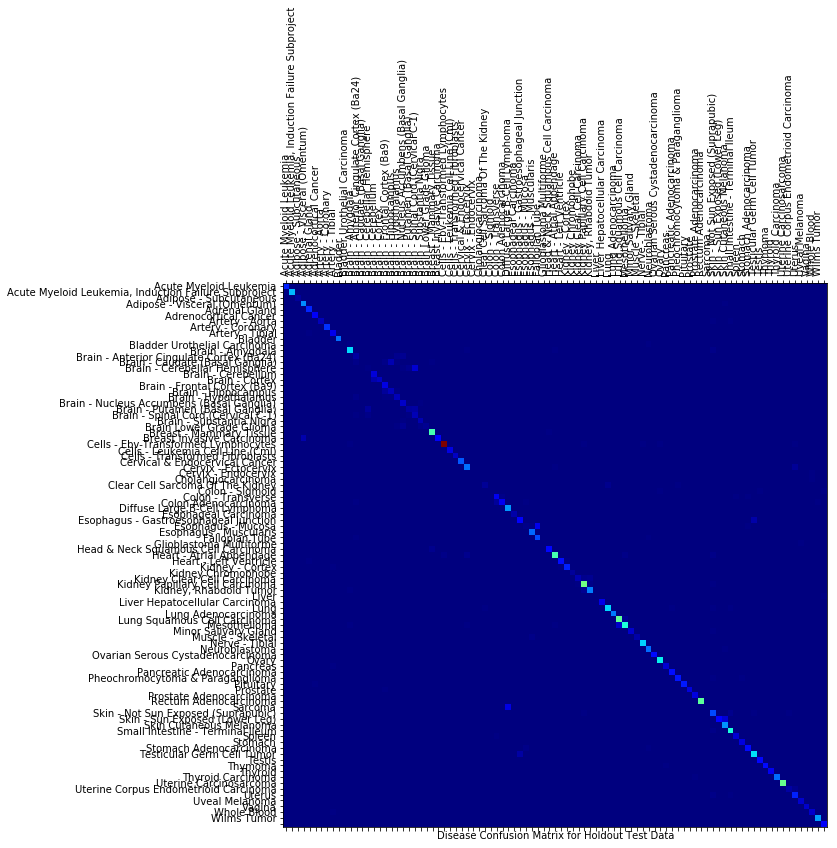

In [16]:
# # Plot  confusion and error matrices
# from sklearn.metrics import confusion_matrix
# plt.matshow(confusion_matrix(disease_test, np.array([np.argmax(p) for p in predictions])), cmap='jet')
# plt.title("Disease Prediction Confusion Matrix")
# plt.show()


# Plot confusion matrix
import sklearn.metrics
import matplotlib.ticker as ticker

confusion_matrix = sklearn.metrics.confusion_matrix(
    disease_test, np.array([np.argmax(p) for p in predictions]))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.jet, interpolation='nearest')
ax.set_xticklabels(disease_encoder.classes_.tolist(), rotation=90)
ax.set_yticklabels(disease_encoder.classes_.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Disease Confusion Matrix for Holdout Test Data")
plt.show()

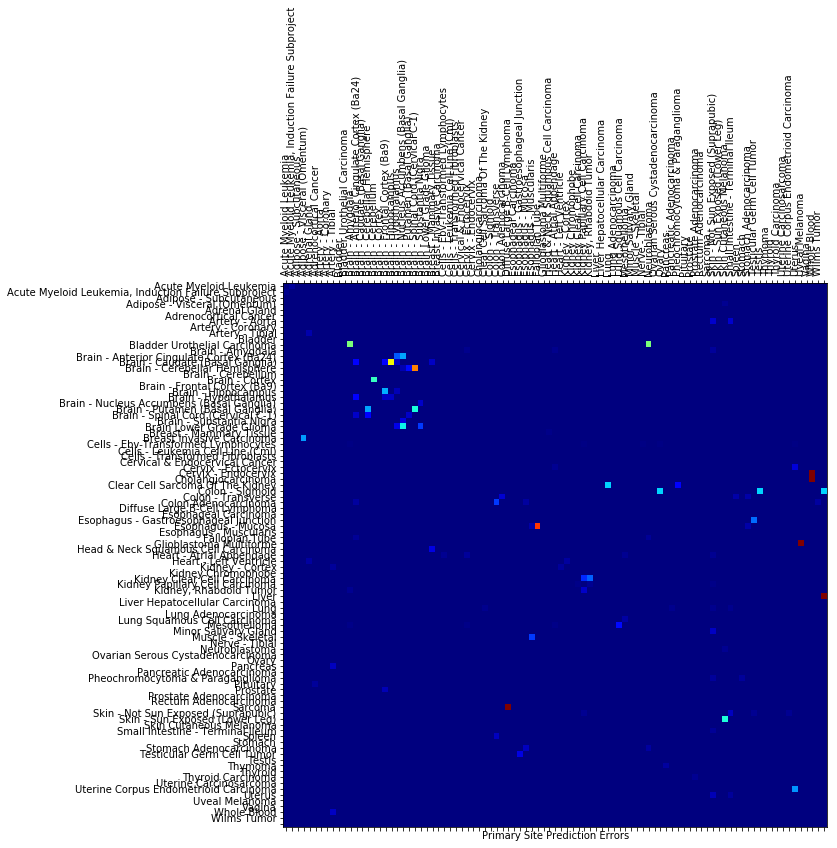

In [19]:
# Show only where there are errors
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = confusion_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.jet, interpolation='nearest')
ax.set_xticklabels(disease_encoder.classes_.tolist(), rotation=90)
ax.set_yticklabels(disease_encoder.classes_.tolist())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Primary Site Prediction Errors")
plt.show()